In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Use pygeos in geopandas
os.environ['USE_PYGEOS'] = '0'

import json
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib as mpl
# import modin.pandas as mpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from glob import glob
from math import comb
from pyproj import Proj
from datetime import date
from copy import deepcopy
from functools import partial
from argparse import Namespace
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
from itertools import islice,product
from tqdm.auto import tqdm
# from modin.config import ProgressBar
# from distributed import Client, LocalCluster
from scipy.spatial.distance import squareform,pdist,cdist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point,LineString, Polygon, mapping, MultiPoint, box


# from gensit.utils import *
# from gensit.notebook_functions import *

# ProgressBar.enable()

# mpl.rcParams['agg.path.chunksize'] = 10000

%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

# Cambridge commuter
## Import table and geometries

In [2]:
# Expertiment id
geometry_name = 'lsoas_to_msoas'
origin_geometry_name = 'lsoa'
destination_geometry_name = 'msoa'
# 'msoa'
# 'lsoa'
# 'oa'
dataset = f'cambridge_work_commuter_{geometry_name}'
table_filename = 'lower_super_output_areas_to_medium_super_output_areas_work_flows_cambridge_2011'
# 'lower_super_output_areas_work_flows_cambridge_2011'
# 'middle_super_output_areas_work_flows_cambridge_2011'
# 'lower_super_output_areas_work_flows_cambridge_2011'
# 'output_areas_work_flows_cambridge_2011'
# 'lower_super_output_areas_to_medium_super_output_areas_work_flows_cambridge_2011'

# Define directory
table_path = f'../data/raw/cambridge_commuter/{table_filename}.csv'
geometries_path = f'../data/raw/cambridge_commuter/cambridge_{geometry_name}.geojson'

In [3]:
# Read in destination attraction
destination_employment = pd.read_csv(f'../data/raw/cambridge_commuter/employment_survey_{destination_geometry_name}.csv',header=None)
destination_employment.columns = [f'{destination_geometry_name}_id','number_of_jobs']
destination_employment[f'{destination_geometry_name}_id'] = destination_employment[f'{destination_geometry_name}_id'].apply(lambda x: x.split(' : ')[0])
destination_employment = destination_employment.sort_values(f'{destination_geometry_name}_id')
destination_number_of_jobs = destination_employment['number_of_jobs'].values

origin_employment = pd.read_csv(f'../data/raw/cambridge_commuter/employment_survey_{origin_geometry_name}.csv',header=None)
origin_employment.columns = [f'{origin_geometry_name}_id','number_of_jobs']
origin_employment[f'{origin_geometry_name}_id'] = origin_employment[f'{origin_geometry_name}_id'].apply(lambda x: x.split(' : ')[0])
origin_employment = origin_employment.sort_values(f'{origin_geometry_name}_id')
origin_number_of_jobs = origin_employment['number_of_jobs'].values

In [4]:
# Read table
table = pd.read_csv(table_path,index_col=0)
# Store first column
origin_geometry_ids = sorted(table.index.values)
destination_geometry_ids = sorted(table.columns.values)
geometry_ids = np.append(origin_geometry_ids,destination_geometry_ids)
# Sort columns and rows alphabetically
table = table[destination_geometry_ids]
table = table.sort_index()
# Convert to array
table = table.values

# Get dimensions
I,J = np.shape(table)

# Read geometries
geometries = gpd.read_file(geometries_path)
# Reproject
geometries = geometries.set_crs('epsg:27700',allow_override=True)

if geometry_name == 'lsoas':
    geometries = geometries.rename(columns={"LSOA11CD":"geometry_id"})
else:
    geometries = geometries.rename(columns={"code":"geometry_id"})

geometries['geometry_id'] = geometries['geometry_id'].astype(str)
geometries = geometries.set_index("geometry_id")
# Reindex by table geometry ids
geometries = geometries.reindex(origin_geometry_ids) if origin_geometry_name == destination_geometry_name else geometries.reindex(origin_geometry_ids+destination_geometry_ids)
geometries = geometries.reset_index()
# Extract centroids
geometries["centroid"] = geometries.centroid
geometries["LONG"] = geometries.centroid.x
geometries["LAT"] = geometries.centroid.y
# Get all relevant columns
geometries = geometries[["geometry_id","LONG","LAT","geometry"]]
geometries.loc[geometries.geometry_id.isin(origin_geometry_ids),'geometry_type'] = origin_geometry_name
geometries.loc[geometries.geometry_id.isin(destination_geometry_ids),'geometry_type'] = destination_geometry_name

# Write geometries to file
# geometries.set_index('geometry_id').to_file(f"../data/inputs/{dataset}/{geometry_name}.geojson", driver='GeoJSON')

# Add rowsums and column sums to geometries
geometries.loc[geometries.geometry_type == origin_geometry_name,'origin_demand'] = table.sum(axis=1)
geometries.loc[geometries.geometry_type == destination_geometry_name,'destination_demand'] = table.sum(axis=0)
geometries.loc[geometries.geometry_type == destination_geometry_name,'number_of_jobs'] = destination_number_of_jobs
geometries.loc[geometries.geometry_type == origin_geometry_name,'number_of_jobs'] = origin_number_of_jobs

# Find all geometries around boundary 
origin_boundary_polygon_ids = geometries[(geometries.geometry_type==origin_geometry_name)&(geometries.intersects(geometries.unary_union.boundary))].geometry_id.values
destination_boundary_polygon_ids = geometries[(geometries.geometry_type==destination_geometry_name)&(geometries.intersects(geometries.unary_union.boundary))].geometry_id.values

In [5]:
# Read in facilities
# facilities = gpd.read_file('../data/raw/cambridge_commuter/facilities.geojson')
facilities = gpd.read_file('../data/raw/cambridge_commuter/facilities_v2.geojson')
facilities = facilities.set_crs('epsg:27700',allow_override=True)
cambridge_facilities = gpd.sjoin(facilities, geometries, how='inner', predicate='within')

# Get only facilities for specific activities
cambridge_facilities = cambridge_facilities[cambridge_facilities['activities'].str.contains('home') | cambridge_facilities['activities'].str.contains('work')]
# Filter out retired and student homes
cambridge_facilities = cambridge_facilities[~(cambridge_facilities['activities'].str.contains('retired_home')) &
                                            ~(cambridge_facilities['activities'].str.contains('student_home')) &
                                            ~(cambridge_facilities['activities'].str.contains('transit'))]

# Discern between home-only and work activities
cambridge_facilities.loc[cambridge_facilities['activities'].str.contains('home',na=False),'main_activity'] = 'home'
cambridge_facilities.loc[~cambridge_facilities['activities'].str.contains('home',na=False),'main_activity'] = 'work'
# cambridge_facilities.loc[~cambridge_facilities['activities'].isin(['home']),'main_activity'] = 'work'

# Create facility_id
cambridge_facilities.loc[:,'facility_id'] = cambridge_facilities['main_activity'] + '_' + cambridge_facilities['id']

# Get all home locations in origin geometry
home_locs = cambridge_facilities[(cambridge_facilities.main_activity == 'home') & (cambridge_facilities.geometry_type == origin_geometry_name)]
# Get all work locations in destination geometry
work_locs = cambridge_facilities[(cambridge_facilities.main_activity == 'work') & (cambridge_facilities.geometry_type == destination_geometry_name)]

In [6]:
# Count number of facilities per geography
work_facility_count = cambridge_facilities[cambridge_facilities['main_activity']=='work'].groupby(['geometry_id']).size().reset_index(name='work_facility_count')
home_facility_count = cambridge_facilities[cambridge_facilities['main_activity']=='home'].groupby(['geometry_id']).size().reset_index(name='home_facility_count')
geometries = pd.merge(geometries,work_facility_count,on='geometry_id',how='left')
geometries = pd.merge(geometries,home_facility_count,on='geometry_id',how='left')

In [7]:
# Convert table to geopandas
table_df = pd.DataFrame(table,index=origin_geometry_ids,columns=destination_geometry_ids)
# Create pairs of flows instead of 2d flows
table_df = table_df.stack().reset_index()
# Rename columns
table_df.rename(columns={"level_0":"origin","level_1":"destination",0:"flow"},inplace=True)
# Attach origin geometry
table_df = table_df.merge(
                geometries[['geometry_id','LONG','LAT','geometry','origin_demand']].set_index('geometry_id'),
                left_on='origin',
                right_index=True,
                how='left'
)
# Rename geometries
table_df.rename(columns={"LONG":"origin_long","LAT":"origin_lat","geometry":"origin_geometry"},inplace=True)
# Attach destination geometry
table_df = table_df.merge(
                geometries[['geometry_id','LONG','LAT','geometry','destination_demand']].set_index('geometry_id'),
                left_on='destination',
                right_index=True,
                how='left'
)
# Rename geometries
table_df.rename(columns={"LONG":"destination_long","LAT":"destination_lat","geometry":"destination_geometry"},inplace=True)

# Convert to geopandas
table_gdf = gpd.GeoDataFrame(table_df,geometry='origin_geometry')


In [8]:
adjacency_matrix = []
for i,orig_geom in geometries[geometries.geometry_type=='lsoa'].iterrows():
    for j,dest_geom in geometries[geometries.geometry_type=='msoa'].iterrows():
        if orig_geom.geometry.intersects(dest_geom.geometry):
            adjacency_matrix.append([orig_geom.geometry_id,dest_geom.geometry_id,1])
            # Add ones to the augmented matrix (origin+destination x origin+destination)
            adjacency_matrix.append([dest_geom.geometry_id,orig_geom.geometry_id,1])
        else:
            adjacency_matrix.append([orig_geom.geometry_id,dest_geom.geometry_id,0])
            # Add zeros to the augmented matrix (origin+destination x origin+destination)
            adjacency_matrix.append([dest_geom.geometry_id,orig_geom.geometry_id,0])

# Add ones to the augmented matrix (origin+destination x origin+destination)
# for i,orig_geom in geometries[geometries.geometry_type=='lsoa'].iterrows():
#     adjacency_matrix.append([orig_geom.geometry_id,orig_geom.geometry_id,1])
# for j,dest_geom in geometries[geometries.geometry_type=='msoa'].iterrows():
#     adjacency_matrix.append([dest_geom.geometry_id,dest_geom.geometry_id,1])

adjacency_matrix = pd.DataFrame(adjacency_matrix,columns=['origin','destination','adjacency'])
adjacency_matrix = adjacency_matrix.pivot(index='origin', columns='destination', values='adjacency')
# Replace nulls with zeros - do this only for the augemented matrix
adjacency_matrix = adjacency_matrix.fillna(0).astype('int32')
# identity_adjacency_matrix = np.ones((I,J),dtype='int32')
# Do this for the augmented matrix
identity_adjacency_matrix = np.ones((I+J,I+J),dtype='int32')

In [43]:
# Region features
region_features = deepcopy(geometries)
region_features['demand'] = region_features['origin_demand'].combine_first(region_features['destination_demand'])
region_features = region_features[['geometry_id','LONG','LAT','demand','number_of_jobs','geometry_type']]
region_features['geometry_id'] = region_features['geometry_id'].astype('str')
region_features = region_features.set_index('geometry_id')

origin_region_features = region_features[region_features.geometry_type=='lsoa'].drop(columns=['geometry_type'])
destination_region_features = region_features[region_features.geometry_type=='msoa'].drop(columns=['geometry_type'])
region_features = region_features.drop(columns=['geometry_type',"LONG","LAT"])

In [46]:
np.save(os.path.join(f'../data/inputs/{dataset}/region_features.npy'),region_features.to_numpy())
# np.save(os.path.join(f'../data/inputs/{dataset}/origin_region_features.npy'),origin_region_features.to_numpy())
# np.save(os.path.join(f'../data/inputs/{dataset}/destination_region_features.npy'),destination_region_features.to_numpy())

In [47]:
cm_filename = """../data/inputs/cambridge_work_commuter_lsoas_to_msoas/cost_matrices/clustered_facilities_sample_20x20_20_01_2023_sample_20x20_clustered_facilities_ripleys_k_500_euclidean_points%_prob_origin_destination_adjusted_normalised_boundary_only_edge_corrected_cost_matrix_max_normalised.txt"""
augmented_cm_filename = cm_filename.replace("cost_matrix","augmented_cost_matrix")
cm = np.loadtxt(cm_filename)
augmented_cm = np.zeros((I+J,I+J),dtype='float32')
for i in range(I):
    for j in range(J):
        augmented_cm[i,I+j] = cm[i,j]
        augmented_cm[I+j,i] = cm[i,j]

In [48]:
augmented_table = np.zeros((I+J,I+J),dtype='int32')
for i in range(I):
    for j in range(J):
        augmented_table[i,I+j] = table[i,j]

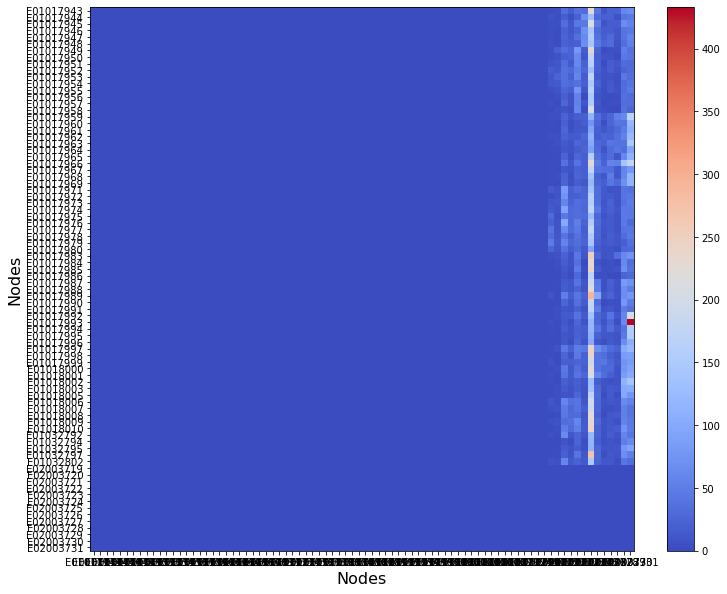

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(augmented_table, cmap=plt.cm.coolwarm, interpolation='nearest')
# ax.set_title('Destination attraction',fontsize=16)
ax.set_ylabel('Nodes',fontsize=16)
ax.set_xlabel('Nodes',fontsize=16)
ax.set_xticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
ax.set_yticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

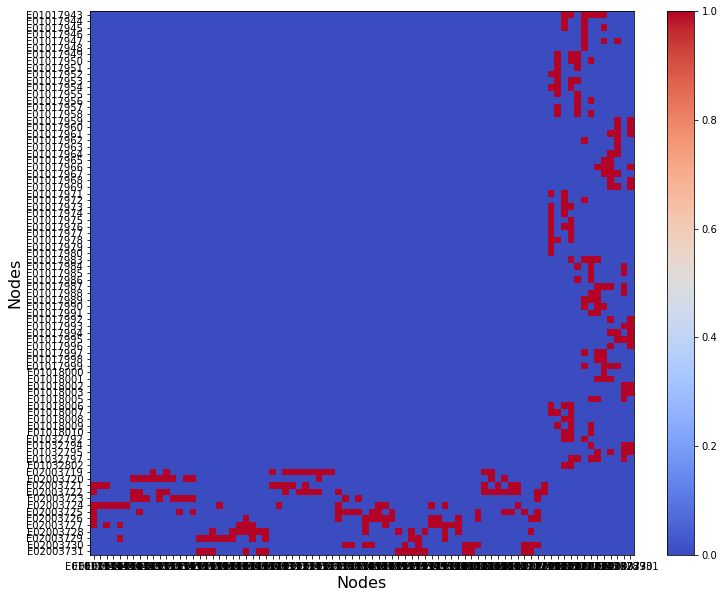

In [50]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(adjacency_matrix, cmap=plt.cm.coolwarm, interpolation='nearest')
# ax.set_title('Destination attraction',fontsize=16)
ax.set_ylabel('Nodes',fontsize=16)
ax.set_xlabel('Nodes',fontsize=16)
ax.set_xticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
ax.set_yticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

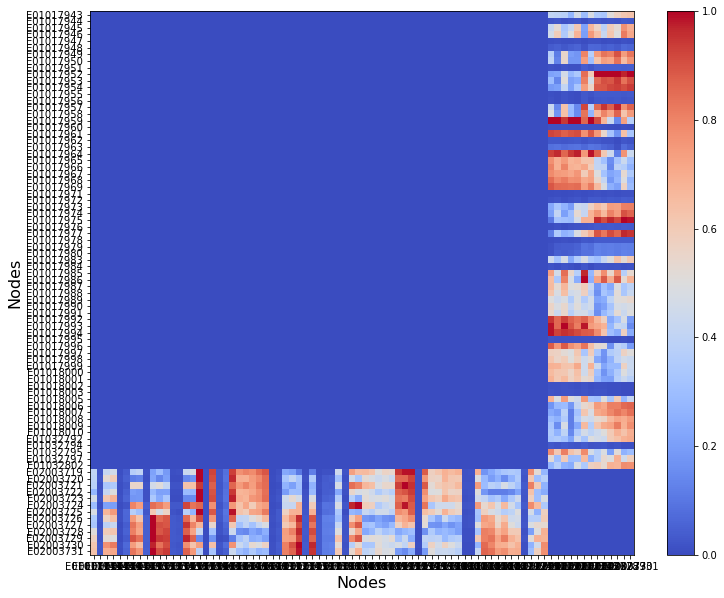

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(augmented_cm, cmap=plt.cm.coolwarm, interpolation='nearest')
# ax.set_title('Destination attraction',fontsize=16)
ax.set_ylabel('Nodes',fontsize=16)
ax.set_xlabel('Nodes',fontsize=16)
ax.set_xticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
ax.set_yticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [16]:
np.savetxt(os.path.join(f'../data/inputs/{dataset}/adjacency_matrix.txt'),adjacency_matrix.values,fmt='%i')
np.savetxt(os.path.join(f'../data/inputs/{dataset}/augmented_table_lsoas_to_msoas.txt'),augmented_table)
np.savetxt(augmented_cm_filename,augmented_cm)

In [17]:
ten_percent_train_cells = np.loadtxt('../data/inputs/cambridge_work_commuter_lsoas_to_msoas/constraints/cell_constraints_permuted_size_90_cell_percentage_10_constrained_axes_0_1_seed_1234.txt')
twenty_percent_train_cells = np.loadtxt('../data/inputs/cambridge_work_commuter_lsoas_to_msoas/constraints/cell_constraints_permuted_size_179_cell_percentage_20_constrained_axes_0_1_seed_1234.txt')

In [18]:
augmented_test_cells = []
augmented_ten_percent_train_cells = []
augmented_twenty_percent_train_cells = []
for i in range(I):
    for j in range(J):
        augmented_test_cells.append([i,I+j])
        if ((i,j) in set(list(map(tuple,ten_percent_train_cells.astype('int32').tolist())))):
            augmented_ten_percent_train_cells.append([i,I+j])
        if ((i,j) in set(list(map(tuple,twenty_percent_train_cells.astype('int32').tolist())))):
            augmented_twenty_percent_train_cells.append([i,I+j])

In [40]:
# Number of origins, destinations used in training
print("10% cell constrained \n",
      f"origins: {len(set(np.array(augmented_ten_percent_train_cells)[:,0]))} \n",
      f"destinations: {len(set(np.array(augmented_ten_percent_train_cells)[:,1]))}")
print("20% cell constrained \n",
      f"origins: {len(set(np.array(augmented_twenty_percent_train_cells)[:,0]))} \n",
      f"destinations: {len(set(np.array(augmented_twenty_percent_train_cells)[:,1]))}")

10% cell constrained 
 origins: 55 
 destinations: 13
20% cell constrained 
 origins: 66 
 destinations: 13


In [19]:
test_cell_matrix = np.zeros((I+J,I+J),dtype='int32')
augmented_ten_percent_train_cell_matrix = np.zeros((I+J,I+J),dtype='int32')
augmented_twenty_percent_train_cell_matrix = np.zeros((I+J,I+J),dtype='int32')
for c in augmented_test_cells:
    test_cell_matrix[tuple(c)] = 1
for c in augmented_ten_percent_train_cells:
    augmented_ten_percent_train_cell_matrix[tuple(c)] = 1
for c in augmented_twenty_percent_train_cells:
    augmented_twenty_percent_train_cell_matrix[tuple(c)] = 1


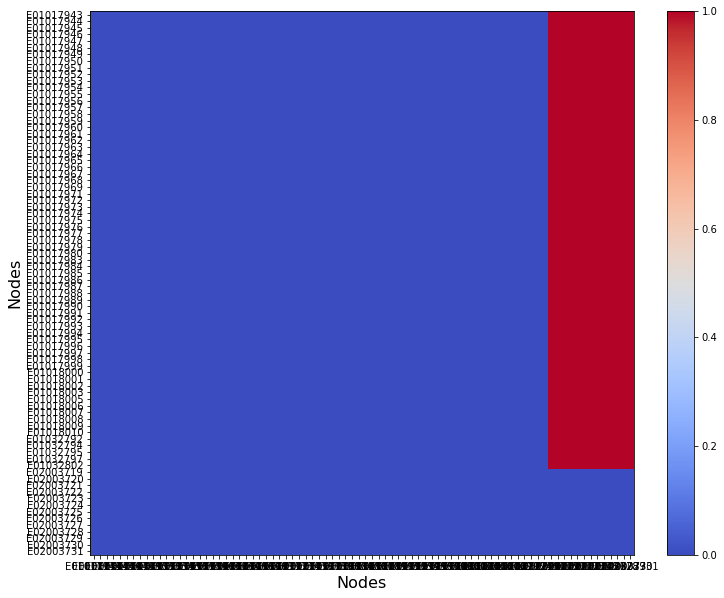

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
plt.imshow(test_cell_matrix, cmap=plt.cm.coolwarm, interpolation='nearest')
ax.set_ylabel('Nodes',fontsize=16)
ax.set_xlabel('Nodes',fontsize=16)
ax.set_xticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
ax.set_yticks(range(I+J),origin_geometry_ids+destination_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [21]:
np.savetxt(
    os.path.join(
        f'../data/inputs/{dataset}/constraints/augmented_test_cells.txt'
    ),np.array(augmented_test_cells)
)
np.savetxt(
    os.path.join(
        f'../data/inputs/{dataset}/constraints/augmented_train_cells_permuted_size_90_cell_percentage_10_constrained_axes_0_1_seed_1234.txt'
    ),np.array(augmented_ten_percent_train_cells)
)
np.savetxt(
    os.path.join(
        f'../data/inputs/{dataset}/constraints/augmented_train_cells_permuted_size_179_cell_percentage_20_constrained_axes_0_1_seed_1234.txt'
    ),np.array(augmented_twenty_percent_train_cells)
)

# Visualise table

In [ ]:
fig, ax = plt.subplots(figsize=(5,10))
plt.imshow(destination_number_of_jobs[:,np.newaxis], cmap=plt.cm.coolwarm, interpolation='nearest')
# ax.set_title('Destination attraction',fontsize=16)
ax.set_ylabel('Destinations',fontsize=16)
ax.set_yticks(range(J),destination_geometry_ids)
ax.set_xticks([])
for j in range(J):
    text = ax.text(0, j, j, ha="center", va="center", color="black")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

### Normalise data

In [ ]:
rowsums = table.sum(axis=1)
colsums = table.sum(axis=0)

In [ ]:
destination_attraction_normalisation_factor = 10000
destination_attraction_normalisation = f'_sum_normalised'
#f'_factor_{destination_attraction_normalisation_factor}_normalised'
#'_sum_normalised'
#'_max_normalised'
#'_factor_{normalisation_factor}_normalised'

origin_demand_normalisation_factor = 1
origin_demand_normalisation = f'_sum_normalised'
#'_sum_normalised'
#'_max_normalised'
#'_factor_{origin_demand_normalisation_factor}_normalised'

In [ ]:
origin_sizes = deepcopy(geometries.loc[(geometries.geometry_type==origin_geometry_name),['geometry_id','origin_demand']])
origin_sizes['origin_demand'] = normalise_data(
    origin_sizes['origin_demand'],
    origin_demand_normalisation,
    origin_demand_normalisation_factor
)

destination_attraction = deepcopy(geometries.loc[(geometries.geometry_type==destination_geometry_name),['geometry_id','number_of_jobs']])
destination_attraction['number_of_jobs'] = normalise_data(
    destination_attraction['number_of_jobs'],
    destination_attraction_normalisation,
    destination_attraction_normalisation_factor
)
destination_attraction['number_of_jobs'] = destination_attraction['number_of_jobs'].astype('float32')
# destination_attraction['number_of_jobs'] = np.log(destination_attraction['number_of_jobs'])

### True kappa and delta

$$\kappa = \frac{\sum_i O_i+\delta M}{\sum_j W_j}$$
$$\delta = \kappa W_{min}$$

In [ ]:
total_w = destination_attraction['number_of_jobs'].values.sum()
min_w = 0.0#np.min(np.exp(destination_attraction['number_of_jobs'].values))
total_o = origin_sizes['origin_demand'].values.sum()
M = destination_attraction.shape[1]
# Compute kappa, delta
kappa = total_o / (total_w - min_w*M)
delta = kappa * min_w

In [ ]:
def kappa_from_delta(d):
    return d / min_w, (total_o+d*M)/total_w
def delta_from_kappa(k):
    return kappa*min_w,(total_w*k-total_o)/M

In [ ]:
total_w,total_o

In [ ]:
kappa,delta

In [ ]:
kappa_from_delta(0.001642710997442455)

In [ ]:
delta_from_kappa(1.1009130103981741)

### Export data to file

In [ ]:
np.savetxt(f'../data/inputs/{dataset}/table_{geometry_name}.txt',table)
np.savetxt(f'../data/inputs/{dataset}/rowsums_{geometry_name}.txt',rowsums)
np.savetxt(f'../data/inputs/{dataset}/colsums_{geometry_name}.txt',colsums)

In [ ]:
np.savetxt(os.path.join(f'../data/inputs/{dataset}/origin_demand{origin_demand_normalisation}.txt'),origin_sizes['origin_demand'].values)
np.savetxt(os.path.join(f'../data/inputs/{dataset}/log_destination_attraction{destination_attraction_normalisation}.txt'),np.log(destination_attraction['number_of_jobs'].values))
np.savetxt(os.path.join(f'../data/inputs/{dataset}/destination_attraction_time_series{destination_attraction_normalisation}.txt'),destination_attraction['number_of_jobs'].values[:,np.newaxis])

np.save(os.path.join(f'../data/inputs/{dataset}/region_features.npy'),region_features.values)
np.save(os.path.join(f'../data/inputs/{dataset}/adjacency_matrix.npy'),adjacency_matrix.values)

### Sample facilities for which shortest path will be computed

In [ ]:
# Number of facilities per geographical unit
n_facilities = None #20
random_seed = 1234 #None
facility_sample_name = f'sample_{n_facilities}' if (n_facilities is not None) else 'all'
facility_name = 'facilities'
import_sample = True

In [ ]:
if not import_sample:
    # Fix seed 
    np.random.seed(random_seed)

    # Sample facilities in each geometry
    home_ids = np.array([])
    work_ids = np.array([])
    for i in tqdm(range(I)):
        # If no home facilities exist compute shortest path to geometry centroid
        if home_locs[home_locs.geometry_id==origin_geometry_ids[i]].size == 0:
            print('No home facilities found in',origin_geometry_ids[i])
            home_ids = np.append(home_ids,origin_geometry_ids[i])
            new_row = pd.DataFrame.from_dict({'facility_id':[origin_geometry_ids[i]],'geometry_id':[origin_geometry_ids[i]],'geometry':geometries[geometries.geometry_id == origin_geometry_ids[i]].centroid})
            home_locs = pd.concat([home_locs, new_row], axis=0, ignore_index=True)
        # If there are less home facilities than sample size take all faciities as origins
        elif (n_facilities is None) or (home_locs[home_locs.geometry_id==origin_geometry_ids[i]].shape[0] < n_facilities):
    #         print('Getting all home facilities found in',geometry_ids[i])
            home_ids = np.append(home_ids,sorted(home_locs[home_locs.geometry_id==origin_geometry_ids[i]].facility_id.values))
        # Sample n_facilities 
        else:
            home_ids = np.append(home_ids,sorted(home_locs[home_locs.geometry_id==origin_geometry_ids[i]].sample(n_facilities).facility_id.values))
    for j in tqdm(range(J)):
        # If no work facilities exist compute shortest path to centroid
        if work_locs[work_locs.geometry_id==destination_geometry_ids[j]].size == 0:
            print('No work facilities found in',destination_geometry_ids[j])
            work_ids = np.append(work_ids,destination_geometry_ids[j])
            new_row = pd.DataFrame.from_dict({'facility_id':[destination_geometry_ids[j]],'geometry_id':[destination_geometry_ids[j]],'geometry':geometries[geometries.geometry_id == destination_geometry_ids[j]].centroid})
            work_locs = pd.concat([work_locs, new_row], axis=0, ignore_index=True)
        # If there are less work facilities than sample size take all faciities as destinations
        elif (n_facilities is None) or (work_locs[work_locs.geometry_id==destination_geometry_ids[j]].shape[0] < n_facilities):
    #         print('Getting all work facilities found in',geometry_ids[j])
            work_ids = np.append(work_ids,sorted(work_locs[work_locs.geometry_id==destination_geometry_ids[j]].facility_id.values))
        # Sample n_facilities
        else:
            work_ids = np.append(work_ids,sorted(work_locs[work_locs.geometry_id==destination_geometry_ids[j]].sample(n_facilities).facility_id.values))

    # Export to file
    home_locs[home_locs.facility_id.isin(home_ids)].drop(columns=['centroid'], errors='ignore').to_file(
            f'../data/inputs/{dataset}/{facility_sample_name}_home_facilities_seed_{random_seed}.geojson',
            driver="GeoJSON")
    work_locs[work_locs.facility_id.isin(work_ids)].drop(columns=['centroid'], errors='ignore').to_file(
            f'../data/inputs/{dataset}/{facility_sample_name}_work_facilities_seed_{random_seed}.geojson',
            driver="GeoJSON")

    print(len(home_ids)*len(work_ids), 'facility pairs sampled')
else:
    home_locs_sampled = gpd.read_file(f'../data/inputs/{dataset}/{facility_sample_name}_home_facilities_seed_{random_seed}.geojson')
    home_ids = np.unique(home_locs_sampled.facility_id.values)
    work_locs_sampled = gpd.read_file(f'../data/inputs/{dataset}/{facility_sample_name}_work_facilities_seed_{random_seed}.geojson')
    work_ids = np.unique(work_locs_sampled.facility_id.values)

## K-means clustering of facilities

In [ ]:
n_origin_clusters = 20#22
n_destination_clusters = 20#21
# Clustered sample must be taken from entire population of facilities
assert n_facilities is None
facility_sample_name = f'sample_{n_origin_clusters}x{n_destination_clusters}'
facility_name = 'clustered_facilities'

import_sample = True

In [ ]:
if not import_sample:
    # Fix seed 
    np.random.seed(random_seed)

    home_ids = []
    work_ids = []

    # Sample origin facilities in each geometry
    for i in tqdm(range(I)):
        # If no home facilities exist compute shortest path to geometry centroid
        if home_locs[home_locs.geometry_id==origin_geometry_ids[i]].size == 0:
            print('No home facilities found in',origin_geometry_ids[i])
            home_ids = np.append(home_ids,
                                 origin_geometry_ids[i])
            new_row = pd.DataFrame.from_dict({'facility_id':[origin_geometry_ids[i]],
                                              'geometry_id':[origin_geometry_ids[i]],
                                              'geometry':geometries[geometries.geometry_id == origin_geometry_ids[i]].centroid})
            home_locs = pd.concat([home_locs, new_row],
                                  axis=0,
                                  ignore_index=True)
        # If there are less home facilities than sample size take all faciities as origins
        elif (home_locs[home_locs.geometry_id==origin_geometry_ids[i]].shape[0] < n_origin_clusters):
            home_ids = np.append(home_ids,
                                 sorted(home_locs[home_locs.geometry_id==origin_geometry_ids[i]].facility_id.values))
        # Cluster facilities
        else:
            # Fit k-means clustering algorithm
            kmeans = KMeans(n_clusters=n_origin_clusters, 
                            random_state=random_seed).fit(list(zip(home_locs[home_locs.geometry_id==origin_geometry_ids[i]].centroid.x.values,
                                                                   home_locs[home_locs.geometry_id==origin_geometry_ids[i]].centroid.y.values)))
            # Add cluster labels to data
            home_locs.loc[home_locs.geometry_id==origin_geometry_ids[i],"cluster_id"] = kmeans.labels_
            # Sample one facility in each cluster
            home_ids = np.append(home_ids,
                                 home_locs[home_locs.geometry_id==origin_geometry_ids[i]].groupby("cluster_id").sample(1).facility_id.values)

    # Sample destination facilities in each geometry
    for j in tqdm(range(J)):
        # If no work facilities exist compute shortest path to centroid
        if work_locs[work_locs.geometry_id==destination_geometry_ids[j]].size == 0:
            print('No work facilities found in',destination_geometry_ids[j])
            work_ids = np.append(work_ids,
                                 destination_geometry_ids[j])
            new_row = pd.DataFrame.from_dict({'facility_id':[destination_geometry_ids[j]],
                                              'geometry_id':[destination_geometry_ids[j]],
                                              'geometry':geometries[geometries.geometry_id == destination_geometry_ids[j]].centroid})
            work_locs = pd.concat([work_locs, new_row],
                                  axis=0,
                                  ignore_index=True)
        # If there are less work facilities than sample size take all faciities as destinations
        elif (work_locs[work_locs.geometry_id==destination_geometry_ids[j]].shape[0] < n_destination_clusters):
            work_ids = np.append(work_ids,
                                 sorted(work_locs[work_locs.geometry_id==destination_geometry_ids[j]].facility_id.values))
        # Sample n_facilities
        else:
            # Fit k-means clustering algorithm
            kmeans = KMeans(n_clusters=n_destination_clusters, 
                            random_state=random_seed).fit(list(zip(work_locs[work_locs.geometry_id==destination_geometry_ids[j]].centroid.x.values,
                                                                   work_locs[work_locs.geometry_id==destination_geometry_ids[j]].centroid.y.values)))
            # Add cluster labels to data
            work_locs.loc[work_locs.geometry_id==destination_geometry_ids[j],"cluster_id"] = kmeans.labels_
            # Sample one facility in each cluster
            work_ids = np.append(work_ids,work_locs[work_locs.geometry_id==destination_geometry_ids[j]].groupby("cluster_id").sample(1).facility_id.values)

    # Export to file
    home_locs[home_locs.facility_id.isin(home_ids)].drop(columns=['centroid'],errors='ignore').to_file(
            f'../data/inputs/{dataset}/clustered_sample_{n_origin_clusters}_home_facilities_seed_{random_seed}.geojson',
            driver="GeoJSON")
    work_locs[work_locs.facility_id.isin(work_ids)].drop(columns=['centroid'],errors='ignore').to_file(
            f'../data/inputs/{dataset}/clustered_sample_{n_destination_clusters}_work_facilities_seed_{random_seed}.geojson',
            driver="GeoJSON")

    print('origins',len(home_ids),'destinations',len(work_ids))
    print(len(home_ids)*len(work_ids), 'facility pairs sampled')
else:
    home_locs_sampled = gpd.read_file(f'../../data/inputs/{dataset}/clustered_sample_{n_origin_clusters}_home_facilities_seed_{random_seed}.geojson')
    home_ids = np.unique(home_locs_sampled.facility_id.values)
    work_locs_sampled = gpd.read_file(f'../../data/inputs/{dataset}/clustered_sample_{n_destination_clusters}_work_facilities_seed_{random_seed}.geojson')
    work_ids = np.unique(work_locs_sampled.facility_id.values)

    print('origins',len(home_ids),'destinations',len(work_ids))
    print(len(home_ids)*len(work_ids), 'facility pairs sampled')

In [ ]:
cost_matrix = np.loadtxt("../data/inputs/cambridge_work_commuter_lsoas_to_msoas/cost_matrices/clustered_facilities_sample_20x20_20_01_2023_sample_20x20_clustered_facilities_ripleys_k_500_euclidean_points%_prob_origin_destination_adjusted_normalised_boundary_only_edge_corrected_cost_matrix_sum_normalised.txt",dtype='float32')

# pd.DataFrame(
#     cost_matrix,
#     index=geometries.loc[(geometries.geometry_type=='lsoa'),'geometry_id'].values,
#     columns=geometries.loc[(geometries.geometry_type=='msoa'),'geometry_id'].values
# ).to_csv('../../NeuralABM/data/HarrisWilson/Cambridge_data/clustered_facilities_sample_20x20_euclidean_20_01_2023_clustered_facilities_sample_20x20_ripleys_k_1000_euclidean_destination_adjusted_normalised_boundary_only_edge_corrected_cost_matrix_sum_normalised.csv',index=True)

### View clustered sample

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
# home_locs.plot(ax=ax)
# home_locs[home_locs.facility_id.isin(home_ids)].plot(ax=ax,color='black',markersize=100)
# geometries[geometries.geometry_type==origin_geometry_name].plot(ax=ax,facecolor='none',edgecolor='blue')
# geometries[geometries.geometry_type==destination_geometry_name].plot(ax=ax,facecolor='none',edgecolor='red')
gpd.GeoDataFrame({"id":[0],"geometry":[geometries.unary_union.boundary]},crs="EPSG:27700").plot(ax=ax,facecolor='none',edgecolor='black')
geometries[(geometries.geometry_type==destination_geometry_name)&(geometries.intersects(geometries.unary_union.boundary))].plot(ax=ax,column="destination_demand")#facecolor='none',edgecolor='red')

### Visualise facilities

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
geometries.plot(facecolor="none",ax=ax)
geometries.centroid.plot(color='black',ax=ax)
cambridge_facilities[cambridge_facilities['main_activity'] == 'home'].plot(color='blue',ax=ax,aspect=1,markersize=1)
cambridge_facilities[cambridge_facilities['main_activity'] == 'work'].plot(color='red',ax=ax,aspect=1,markersize=1)
plt.show()

# 
# 
# 
# Construct transportation network graph 

In [ ]:
import_graph = True

if import_graph:
    
    # Read graph pickle from file
    graph = nx.read_gpickle(os.path.join(f'../data/raw/cambridge_commuter/{geometry_name}_graph.gpickle'))
    
    network_and_origin_destination_vertices = gpd.read_file(f'../data/raw/cambridge_commuter/{geometry_name}_graph_nodes_network_and_origin_destination.geojson',index_col=0)
    network_and_origin_destination_nodes = network_and_origin_destination_vertices.set_index('id')
    home_nodes = network_and_origin_destination_nodes.loc[network_and_origin_destination_nodes.node_type=='home',['geometry']].to_dict()['geometry']
    work_nodes = network_and_origin_destination_nodes.loc[network_and_origin_destination_nodes.node_type=='work',['geometry']].to_dict()['geometry']
    network_nodes = network_and_origin_destination_nodes.loc[network_and_origin_destination_nodes.node_type=='network',['geometry']].to_dict()['geometry']

    network_and_origin_destination_nodes = {**network_nodes,**home_nodes,**work_nodes}
    facility_nodes = {**home_nodes,**work_nodes}
else:    

    # Read network file
    network_filename = f'../data/raw/cambridge_commuter/network.geojson'
    network = gpd.read_file(network_filename)
    network = network.set_crs('epsg:27700',allow_override=True)

    # Extract edges and nodes
    vertices = network[network['geometry'].apply(lambda x : x.type=='Point')]
    edges = network[network['geometry'].apply(lambda x : x.type!='Point')]

    # Add nodes to graph
    network_nodes = {}
    geography_nodes = {}
    work_nodes = {}
    home_nodes = {}

    # Classify facility points into homes and workplaces
    for _,fac in tqdm(cambridge_facilities.iterrows(),total=cambridge_facilities.shape[0]):
        if fac.main_activity == 'home':
            home_nodes[fac.facility_id] = [(fac.geometry.x,fac.geometry.y),'home']
        elif fac.main_activity == 'work':
            work_nodes[fac.facility_id] = [(fac.geometry.x,fac.geometry.y),'work']
        else:
            print(fac.facility_id,fac.main_activity)
            raise
    # Store all network vertices
    for i,v in tqdm(vertices.iterrows(),total=vertices.shape[0]):
        network_nodes[v.id] = [(v.geometry.x,v.geometry.y),'network']

    # Add geography centroids as nodes in graph
    for _,g in tqdm(geometries.iterrows(),total=geometries.shape[0]):
        geography_nodes[g.geometry_id] = [(g.geometry.centroid.x,g.geometry.centroid.y),'geography']

    # Merge nodes into groups
    network_and_origin_destination_nodes = {**network_nodes,**home_nodes,**work_nodes}
    facility_nodes = {**home_nodes,**work_nodes}
    # Network and origin vertices
    network_and_origin_destination_vertices = pd.DataFrame.from_dict(network_and_origin_destination_nodes,
                                                                    orient='index',
                                                                    columns=['geometry','node_type']).reset_index().rename(columns={'index': 'id'}
                                            )
    network_and_origin_destination_vertices.geometry = network_and_origin_destination_vertices.geometry.apply(Point)
    network_and_origin_destination_vertices = gpd.GeoDataFrame(network_and_origin_destination_vertices,crs='epsg:27700')

    network_and_origin_destination_vertices.set_index('id').to_file(f'../data/raw/cambridge_commuter/{geometry_name}_graph_nodes_network_and_origin_destination.geojson',index=True)

    # Create graph from network
    graph = nx.MultiDiGraph()

    # Add facility points as nodes in graph
    for _,fac in tqdm(cambridge_facilities.iterrows(),total=cambridge_facilities.shape[0]):
        graph.add_node(fac.facility_id,pos=(fac.geometry.x,fac.geometry.y),activity=fac.main_activity)

    # Store all network vertices in networkx object
    for i,v in tqdm(vertices.iterrows(),total=vertices.shape[0]):
        graph.add_node(v.id,pos=(v.geometry.x,v.geometry.y),activity='other')

    # Add geography centroids as nodes in graph
    for _,g in tqdm(geometries.iterrows(),total=geometries.shape[0]):
        graph.add_node(g.geometry_id,pos=(g.geometry.centroid.x,g.geometry.centroid.y),activity='other')

    # Construct a spatial tree to find nearest point in graph
    tree = KDTree(list(map(list, zip(*network_nodes.values())))[0])

    # Store all network edges in networkx object
    for i,e in tqdm(edges.iterrows(),total=edges.shape[0]):
        for mode in e['modes'].split(','):
            graph.add_edge(e['fromNode'],
                           e['toNode'],
                           mode=mode,
                           weight=float(e['length']),
                           capacity=float(e['capacity']),
                           length=float(e['length']))

    # For every geography centroid add an edge to the closest vertex on graph
    for node in tqdm(geography_nodes.keys(),total=len(geography_nodes)):
        # Get nearest node and its distance
        nearest_dist, nearest_ind = tree.query(geography_nodes[node][0], k=1)
        # Get closest point in network 
        network_node = list(network_nodes.keys())[nearest_ind]
        network_point = network_nodes[network_node][0]
        # Add artificial links geography centroids as nodes in graph
        graph.add_edge(node,
                       network_node,
                       mode='walk',
                       weight=float(nearest_dist),
                       capacity=float(nearest_dist),
                       length=float(nearest_dist))
        graph.add_edge(network_node,
                       node,
                       mode='walk',
                       weight=float(nearest_dist),
                       capacity=float(nearest_dist),
                       length=float(nearest_dist))

    # For every facility centroid add an edge to the closest vertex on graph
    for node in tqdm(facility_nodes.keys(),total=len(facility_nodes)):
        # Get nearest node and its distance
        nearest_dist, nearest_ind = tree.query(facility_nodes[node][0], k=1)
        # Get closest point in network 
        network_node = list(network_nodes.keys())[nearest_ind]
        network_point = network_nodes[network_node][0]
        # Add artificial links geography centroids as nodes in graph
        graph.add_edge(node,
                       network_node,
                       mode='walk',
                       weight=float(nearest_dist),
                       capacity=float(nearest_dist),
                       length=float(nearest_dist))
        graph.add_edge(network_node,
                       node,
                       mode='walk',
                       weight=float(nearest_dist),
                       capacity=float(nearest_dist),
                       length=float(nearest_dist))

    # Remove self loops
    graph.remove_edges_from(list(nx.selfloop_edges(graph, keys=True)))
    
    # Write to file
    nx.write_gpickle(graph,os.path.join(f'../data/raw/cambridge_commuter/{geometry_name}_graph.gpickle'))

# Get all edge data
# edges_gdf = [[(e[0]+'_'+e[1]),LineString([Point(graph.nodes[e[0]]['pos']),Point(graph.nodes[e[1]]['pos'])]),e[2]['mode'],e[2]['weight'],e[2]['length']] for e in graph.edges(data=True)]
# edges_gdf = gpd.GeoDataFrame(pd.DataFrame(edges_gdf,columns=['id','geometry','mode','weight','length']))

### Visualise transportation network graph

In [ ]:
# # Get modal subgraph(s)
# selected_edges = [(u,v,e['mode']) for u,v,e in graph.edges(data=True) if e['mode'] in ['bus','car','walk'] ]
# H = graph.edge_subgraph(selected_edges)
# pos = nx.get_node_attributes(H, 'pos')

# origin_node,destination_node = 'home_72000256','work_315112358'

# # Find shortest path between two nodes
# spath = nx.shortest_path(graph,origin_node,destination_node)
# H2 = graph.subgraph(spath)
# spath_edges = list(zip(spath,spath[1:]))
# pos2 = nx.get_node_attributes(H2, 'pos')

# # Get bounding box of selected nodes
# bbox = box(*MultiPoint(list([x[1] for x in H2.nodes(data="pos")])).bounds, ccw=True)
# xmin,ymin,xmax,ymax = bbox.bounds
# # Find all nodes within that box
# relevant_nodes = [n[0] for n in H2.nodes(data="pos") if bbox.contains(Point(n[1]))]
# new_nodes = list(set(relevant_nodes)-set(spath))
# # Get all relevant edges
# H3 = graph.subgraph(relevant_nodes)
# # Get position
# pos3 = nx.get_node_attributes(H3, 'pos')

# # Remove all home/work nodes except 2 above
# removed_nodes = [node for node in H.nodes if (node.startswith('work') or node.startswith('home'))]
# removed_nodes = list(set(removed_nodes)-set([origin_node,destination_node]))
# # Remove edges
# kept_edges = []
# for u,v,e in tqdm(selected_edges):
#     if not (u in removed_nodes or v in removed_nodes):
#         kept_edges.append((u,v))
# # Remove all such nodes
# H = H.copy()
# H.remove_nodes_from(removed_nodes)

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(20,20))

# # convert lat and lon to map projection
# mx,my=m([xminr,xmaxr],[yminr,ymaxr])

# nx.draw_networkx_nodes(H,
#                        nx.get_node_attributes(H, 'pos'),
#                        nodelist=H.nodes,
#                        node_color='blue',
#                        node_size=1,
#                        ax=ax)

# nx.draw_networkx_edges(H,
#                        nx.get_node_attributes(H, 'pos'),
#                        edgelist=kept_edges,
#                        edge_color='black',
#                        width=1,
#                        arrows=False,
#                        arrowsize=14,
#                        arrowstyle='-|>', 
#                        alpha=0.4,
#                        ax=ax)

# # Draw shortest path
# nx.draw_networkx_nodes(H2,pos2,nodelist=spath,node_color='r',node_size=2)
# nx.draw_networkx_edges(H2,pos2,edgelist=spath_edges,edge_color='r',width=3)

# # Plot bounding box
# ax.plot([xmin-pad,xmax+pad,xmax+pad,xmin-pad,xmin-pad],[ymin-pad,ymin-pad,ymax+pad,ymax+pad,ymin-pad],color='black')

# # Limit x axis
# plt.xlim(xmin-pad,xmax+pad)
# plt.ylim(ymin-pad,ymax+pad)

# # Add basemap
# cx.add_basemap(ax, crs=edges.crs, source=cx.providersStamen.Watercolor)


# plt.show()

# 
# 
# 
# Compute/import edge effect corrections

In [ ]:
import_edge_corrections = True

if import_edge_corrections:
    edge_corrections = gpd.read_file(f'../data/inputs/{dataset}/edge_corrections.geojson')
    edge_corrections.crs = geometries.crs
else:
    edge_corrections = deepcopy(geometries[['geometry_id','geometry','geometry_type']])

### Method 1: Boundary geography centroid enclosed angles 

In [ ]:
if not import_edge_corrections:
    # Compute percentage of angle enclosed in boundary
    angle_covered = compute_centroid_boundary_enclosed_angle(geometries[geometries.geometry_type==destination_geometry_name])
    # Pass it to geometries df
    edge_corrections.loc[:,'angle_covered'] = edge_corrections.loc[:,'geometry_id'].map(angle_covered)

### Visualise method 1

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ps = list(MultiPoint(geometries.centroid).convex_hull.boundary.coords)
xx, yy = [x[0] for x in ps], [y[1] for y in ps]
geometries.plot(facecolor="none",ax=ax)
geometries.plot(column="number_of_jobs",cmap='RdYlGn',legend=True,legend_kwds={'fraction':0.046,'pad':0.04},ax=ax)
geometries.centroid.plot(color='black',ax=ax)
ax.plot(xx,yy)
# cambridge_facilities[cambridge_facilities['main_activity'] == 'home'].plot(color='blue',ax=ax,aspect=1,markersize=1)
# cambridge_facilities[cambridge_facilities['main_activity'] == 'work'].plot(color='red',ax=ax,aspect=1,markersize=1)
plt.show()

### Method 2: Compute angle covered by outmost destination zones located on convex hull

In [ ]:
if not import_edge_corrections:
    # Get all facility locations from sampling pool
    facility_location_sample_pool = gpd.GeoDataFrame( pd.concat( [home_locs,work_locs], ignore_index=True) )
    # Get all sampled faclitiies
    sampled_locs = facility_location_sample_pool[facility_location_sample_pool.facility_id.isin(np.append(home_ids,work_ids))]
    # Get all points in convex hull of sampled facilities
    convex_hull_boundary_points = MultiPoint(sampled_locs.geometry.values).convex_hull.boundary.coords

    # Collect all boundary facility ids
    boundary_facility_ids = []
    for chp in convex_hull_boundary_points:
        boundary_facility_ids.append(sampled_locs[sampled_locs.geometry.geom_almost_equals(Point(chp))].facility_id.values[0])
    # Collect all boundary work facilities    
    boundary_work_facilities = facility_location_sample_pool[facility_location_sample_pool.facility_id.isin([wid for wid in boundary_facility_ids if wid.startswith('work')])]
    # Compute convex hull of collected work facilities
    boundary_work_facilities_boundary = MultiPoint(boundary_work_facilities.geometry.values).convex_hull.boundary.coords


    # Computer destination facility boundary adjustment
    sampled_facility_angles_covered = compute_sampled_facility_boundary_enclosed_angle(
        home_locs[home_locs.facility_id.isin(home_ids)],
        boundary_work_facilities,
        statistic='max'
    )
    # Merge them into non-adjusted destinations
    all_facilities_angles_covered = dict(zip(geometry_ids,np.ones(len(geometry_ids))))
    all_facilities_angles_covered.update(sampled_facility_angles_covered)
    sampled_facility_angles_covered = all_facilities_angles_covered 

    # Pass it to geometries df
    edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_max_angle_covered'] = edge_corrections.loc[:,'geometry_id'].map(sampled_facility_angles_covered)

### Visualise boundary work facilities

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(30,20))
# ax.set_title('Sampled facilities')
# # boundary_work_facilities.plot(ax=ax,color='black',markersize=100)
# # gpd.GeoDataFrame(index=[0], crs='epsg:27700', geometry=[MultiPoint(boundary_work_facilities.geometry.values).convex_hull]).plot(ax=ax,facecolor='none',edgecolor='green')

# # edge_corrections.plot(column=f"ripleys_k_{neighbourhood_method_name}_normalised",cmap='RdYlGn',legend=True,legend_kwds={'fraction':0.046,'pad':0.04},ax=ax)
# # home_locs[home_locs.facility_id.isin(home_ids)].geometry.plot(ax=ax,color='blue')
# home_locs.plot(ax=ax,color='blue',markersize=5)
# work_locs.plot(ax=ax,color='red',markersize=5)
# geometries.plot(facecolor="none",edgecolor='black',ax=ax)
# plt.show()

### Method 3: Compute average angle covered based on facilities of nearby zones

In [ ]:
# Number of cores to parallelise across
num_cores = 4

In [ ]:
if (n_facilities is not None) or ((n_origin_clusters > 0) and (n_destination_clusters > 0)):
    # Find ids of polygons around the boundary
    if not import_edge_corrections:

        facility_average_neighbour_angle = compute_sampled_facility_neighbourhood_enclosed_angle(
            home_locs[(home_locs.geometry_id.isin(origin_boundary_polygon_ids)) & (home_locs.facility_id.isin(home_ids))],
            work_locs[(work_locs.geometry_id.isin(destination_boundary_polygon_ids)) & (work_locs.facility_id.isin(work_ids))],
            geometries[(geometries.geometry_type==origin_geometry_name)&(geometries.intersects(geometries.unary_union.boundary))],
            geometries[(geometries.geometry_type==destination_geometry_name)&(geometries.intersects(geometries.unary_union.boundary))],
            statistic = 'mean',
            n_workers = num_cores
        )

        # Merge them into non-adjusted destinations
        all_facilities_angles_covered = dict(zip(destination_geometry_ids,np.ones(len(destination_geometry_ids))))
        all_facilities_angles_covered.update(facility_average_neighbour_angle)
        facility_average_neighbour_angle = all_facilities_angles_covered 

        # Pass it to geometries df
        edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_average_neighbourhood_angle_covered'] = edge_corrections.loc[:,'geometry_id'].map(facility_average_neighbour_angle)

### Visualise boundary geometries

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sampled facilities')
edge_corrections[edge_corrections.geometry_id.isin(origin_boundary_polygon_ids)].plot(column=f'{facility_sample_name}_{facility_name}_average_neighbourhood_angle_covered',
                                                                          cmap='RdYlGn',
                                                                          legend=True,
                                                                          legend_kwds={'fraction':0.046,'pad':0.04},
                                                                          ax=ax)
home_locs[(home_locs.geometry_id.isin(origin_boundary_polygon_ids)) & (home_locs.facility_id.isin(home_ids))].plot(ax=ax,color='blue',markersize=5)
work_locs[(work_locs.geometry_id.isin(destination_boundary_polygon_ids)) & (work_locs.facility_id.isin(work_ids))].plot(ax=ax,color='red',markersize=5)
for gid in origin_boundary_polygon_ids:
    plt.annotate(text=gid,xy=(geometries[geometries.geometry_id==gid].centroid.values[0].x,geometries[geometries.geometry_id==gid].centroid.values[0].y))
plt.show()

### Method 4: Ripley's k function

In [ ]:
# Parallelisation parameters
num_cores = 4
buffer_radius = 500
neighbourhood_method_name = 'euclidean'
conditional_probabilty_method_name = 'points%'
location_type = 'origin_destination'
#'area%' 'points%'

In [ ]:
if not import_edge_corrections:
    # Add region geometry to origins
    orig_locs = pd.merge(home_locs[home_locs.facility_id.isin(home_ids)],
                        geometries[['geometry_id','geometry']].rename(columns={"geometry":"region_geometry"}),
                        on='geometry_id',
                        how='left')[['geometry','geometry_id','region_geometry','facility_id','main_activity']]
    # Add region geometry to destinations
    dest_locs = pd.merge(work_locs[work_locs.facility_id.isin(work_ids)],
                        geometries[['geometry_id','geometry']].rename(columns={"geometry":"region_geometry"}),
                        on='geometry_id',
                        how='left')[['geometry','geometry_id','region_geometry','facility_id','main_activity']]
    dest_locs.loc[dest_locs.facility_id.str.startswith('E'),'main_activity'] = 'work'


    ripleys_k_edge_correction, ripleys_k_origin_responsibility,ripleys_k_destination_responsibility = apply_ripleys_k_edge_correction(
        index=0,
        aoi_locations=orig_locs,
        geographies=geometries,
        G=graph,
        location_type=location_type,
        radius=buffer_radius,
        neighbourhood_method=neighbourhood_method_name,
        conditional_probabilty_method=conditional_probabilty_method_name,
    )

In [ ]:
if not import_edge_corrections:
    # Pass it to geometries df
    edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_{neighbourhood_method_name}_{conditional_probabilty_method_name}_prob_origin_adjusted'] = edge_corrections.loc[:,'geometry_id'].map({k:v['origin'] for k,v in ripleys_k_edge_correction.items()})
    edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_{neighbourhood_method_name}_{conditional_probabilty_method_name}_prob_destination_adjusted'] = edge_corrections.loc[:,'geometry_id'].map({k:v['destination'] for k,v in ripleys_k_edge_correction.items()})

    # Normalise it
    ripleys_l_edge_correction_normalised = {k:{"origin":(np.pi*buffer_radius**2)/v['origin'],
                                            "destination":(np.pi*buffer_radius**2)/v['destination']} \
                                            for k,v in ripleys_k_edge_correction.items()}

    # Pass it to geometries df
    edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_{neighbourhood_method_name}_{conditional_probabilty_method_name}_prob_origin_adjusted_normalised'] = edge_corrections.loc[:,'geometry_id'].map({k:v['origin'] for k,v in ripleys_l_edge_correction_normalised.items()})
    edge_corrections.loc[:,f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_{neighbourhood_method_name}_{conditional_probabilty_method_name}_prob_destination_adjusted_normalised'] = edge_corrections.loc[:,'geometry_id'].map({k:v['destination'] for k,v in ripleys_l_edge_correction_normalised.items()})

    # Merge home locations with their ripley responsibility
    home_locs = pd.merge(home_locs,ripleys_k_origin_responsibility[['facility_id',f'ripleys_k']],on='facility_id',how='left')
    work_locs = pd.merge(work_locs,ripleys_k_destination_responsibility[['facility_id',f'ripleys_k']],on='facility_id',how='left')

### Visualise Ripley's k function adjustment

In [ ]:
facility_name = 'clustered_facilities' #'facilities' # clustered_facilities
facility_sample_name = 'sample_20x20' #'all' # sample_20x20
conditional_probabilty_method_name = 'points%'

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
boundary_only = True

if conditional_probabilty_method_name != "":
    conditional_probabilty_method_name_suffix = "_prob_"
else:
    conditional_probabilty_method_name_suffix = ""
col_name = f"{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_{neighbourhood_method_name}_{conditional_probabilty_method_name}{conditional_probabilty_method_name_suffix}{location_type}_adjusted_normalised"
if boundary_only:
    boundary_only = edge_corrections.geometry.intersects(edge_corrections.unary_union.exterior)
else:
    boundary_only = True

ax.set_title(col_name.replace("_"," ").capitalize())
edge_corrections[(edge_corrections.geometry_type==geom_name) & boundary_only ].plot(
    column=col_name,
    cmap='RdYlGn',
    legend=True,
    legend_kwds={'fraction':0.046,'pad':0.04},
    ax=ax
)
if plot_origin:
    home_locs[home_locs.facility_id.isin(home_ids) & home_locs.geometry_id.isin(origin_boundary_polygon_ids)].geometry.plot(ax=ax,color='blue')
else:
    work_locs[work_locs.facility_id.isin(work_ids) & work_locs.geometry_id.isin(destination_boundary_polygon_ids)].geometry.plot(ax=ax,color='blue')
# home_locs[home_locs.facility_id == 'home_255522216'].geometry.plot(ax=ax,color='black',markersize=100)
# home_locs[home_locs.facility_id == 'home_255522216'].buffer(buffer_radius).plot(ax=ax,edgecolor='black',linewidth=5,facecolor='None')
geometries[geometries.geometry_type==geom_name].plot(facecolor="none",edgecolor='black',ax=ax)
# geometries[geometries.geometry_type==destination_geometry_name].plot(facecolor="none",edgecolor='black',ax=ax)
plt.show()

## Export edge corrections

In [ ]:
printcols(edge_corrections)

In [ ]:
if not import_edge_corrections:
    edge_corrections.to_file(
        f'../data/inputs/{dataset}/edge_corrections.geojson',
        driver='GeoJSON',
        index=False
    )

# 
# 
# 
# 
# Compute cost matrices
## Euclidean cost matrix

In [ ]:
# Choose cost_matrix calculation method
cost_matrix_method = 'euclidean_centroids'
# 'euclidean_centroids'

In [ ]:
# Euclidean distance between centroids
centroid_euclidean_cost_matrix = pd.DataFrame(
        cdist(
                geometries.loc[geometries.geometry_type==origin_geometry_name, ["LAT","LONG"]],
                geometries.loc[geometries.geometry_type==destination_geometry_name, ["LAT","LONG"]]
        ), 
        columns=destination_geometry_ids,
        index=origin_geometry_ids
)

## Centroid shortest path cost computation

In [ ]:
import_ct = True

if not import_ct:
    # Find shortest path between geography centroids in graph
    centroid_shortest_path_cost_matrix = np.zeros((I,J))
    for i in tqdm(range(len(origin_geometry_ids))):
        for j in range(i+1,len(destination_geometry_ids)):
            centroid_shortest_path_cost_matrix[i,j] = nx.shortest_path_length(
                                                            graph,
                                                            origin_geometry_ids[i],
                                                            destination_geometry_ids[j],
                                                            weight='length',
                                                            method='dijkstra'
                                                    )
            centroid_shortest_path_cost_matrix[j,i] = nx.shortest_path_length(
                                                            graph,
                                                            destination_geometry_ids[j],
                                                            origin_geometry_ids[i],
                                                            weight='length',
                                                            method='dijkstra'
                                                    )

    # Convert to df
    centroid_shortest_path_cost_matrix = pd.DataFrame(
                                                centroid_shortest_path_cost_matrix,
                                                columns=destination_geometry_ids,
                                                index=origin_geometry_ids
                                        )
    # Save to file
    centroid_shortest_path_cost_matrix.to_csv(
        f'../data/inputs/{dataset}/cost_matrices/geometry_centroid_shortest_path_cost_matrix.csv',
        index=True
    )
else:
    # Read from file
    centroid_shortest_path_cost_matrix = pd.read_csv(
            f'../data/inputs/{dataset}/cost_matrices/geometry_centroid_shortest_path_cost_matrix.csv',
            index_col=0
    )

## Facility centroid shortest path cost computation

In [ ]:
import_ct = True
try:
    assert facility_sample_name == 'all'
except:
    raise ValueError(f'Facility centroid computed across all available facilities and not for {facility_sample_name}')

if not import_ct:

    # Find mean shortest paths between facility within geography in graph
    facility_centroid_shortest_path_cost_matrix = np.zeros((I,J))
    for i,j in tqdm(list(itertools.product(range(I),range(J))),total=(I*J)):
        # Get all home locations in origin geometry
        geography_home_locs = cambridge_facilities[(cambridge_facilities.geometry_id == origin_geometry_ids[i]) & \
                                                   (cambridge_facilities.main_activity == 'home')]
        # Get all work locations in destination geometry
        geography_work_locs = cambridge_facilities[(cambridge_facilities.geometry_id == destination_geometry_ids[j]) & \
                                                    (cambridge_facilities.main_activity == 'work')]

        # Find vertices closest to home locs centroid and work locs centroid
        closest_to_home_centroid = home_locs.sindex.nearest(home_locs.dissolve().centroid)
        closest_to_work_centroid = work_locs.sindex.nearest(geography_work_locs.dissolve().centroid)

        # If no home facilities exist compute shortest path to geometry centroid
        if home_locs.size == 0:
            home = geometry_ids[i]
        # Else compute compute shortest path to home closest to centroid of all homes
        else:
            home = home_locs.iloc[closest_to_home_centroid[1]].facility_id.values[0]

        # If no work facilities exist compute shortest path to centroid
        if work_locs.size == 0:
            work = geometry_ids[j]
        # Else compute compute shortest path to workplace closest to centroid of all workplaces
        else:
            work = work_locs.iloc[closest_to_work_centroid[1]].facility_id.values[0]

        # Calculate shortest paths from centroid of home facilities to centroid of work facilities and vice versa
        home_to_work_sp = nx.shortest_path_length(graph,home,work,weight='length',method='dijkstra')

        # Compute mean shortest path length from home to work and vice versa    
        facility_centroid_shortest_path_cost_matrix[i,j] = home_to_work_sp
        
    # Convert to df
    facility_centroid_shortest_path_cost_matrix = pd.DataFrame(facility_centroid_shortest_path_cost_matrix,
                                                               columns=destination_geometry_ids,
                                                               index=origin_geometry_ids)
    # Save to file
    facility_centroid_shortest_path_cost_matrix.to_csv(
        '../data/inputs/{dataset}/cost_matrices/{facility_name}_centroid_{facility_sample_name}_shortest_path_cost_matrix.csv',
        index=True
    )

else:
    # Read from file
    facility_centroid_shortest_path_cost_matrix = pd.read_csv(
            f'../data/inputs/{dataset}/cost_matrices/{facility_name}_centroid_{facility_sample_name}_shortest_path_cost_matrix.csv',                                    
            index_col=0
    )

## Individual facility cost computation
### Shortest path or euclidean

In [ ]:
# Parallelisation parameters
num_cores = 1
# Number batches/chunks to split origin locations into
n_batches = 100
# Distance Method
distance_method = 'euclidean'
# 'euclidean'
# 'shortest_path'
print_flag = False
store = False

date_computed = '25_01_2023'
# '13_12_2022'
# '08_12_2022'
# '25_01_2023'

In [ ]:
import_facility_cm = True

if import_facility_cm:
    # Get filename
    facility_cost_filename = f'facilities_all_{distance_method}_{date_computed}'
    
    # Import pickle
    individual_facility_distance_matrix_gdf = pd.read_pickle(f'../data/raw/cambridge_commuter/{facility_cost_filename}.pickle')
    
else:
    # Find mean distance between all facilities within geography in graph
    
    # Split inputs into batches/chunks
    home_ids_batches = np.array_split(home_ids,n_batches)

    # Compute shortest paths in parallel
    if distance_method == 'shortest_path':
        individual_facility_distance_matrices = np.asarray(Parallel(n_jobs=num_cores,
                                                      prefer="threads")(
                                                delayed(compute_individual_facility_shortest_path)(i,
                                                        graph,
                                                       home_ids_batches[i],
                                                       work_ids,
                                                       n_batches,
                                                       store) for i in tqdm(range(n_batches),leave=True)),dtype=object)
    elif distance_method == 'euclidean':
        selected_work_locs = work_locs.loc[work_locs.facility_id.isin(work_ids),['facility_id','geometry']]
        individual_facility_distance_matrices = np.asarray(Parallel(n_jobs=num_cores,backend='multiprocessing')(
                                            delayed(compute_individual_facility_euclidean_distance)(i,
                                                dict(zip(home_locs.loc[home_locs.facility_id.isin(home_ids_batches[i]),'facility_id'].values,
                                                         home_locs.loc[home_locs.facility_id.isin(home_ids_batches[i]),'geometry'].values)),
                                                dict(zip(selected_work_locs['facility_id'],
                                                         selected_work_locs['geometry'])),
                                               print_flag) for i in tqdm(range(n_batches),leave=True)),dtype=object)
    else:
        raise ValueError(f'No distance method {distance_method} found')
    # Convert to df
    print('Convert to df')
    individual_facility_distance_matrix_gdf = pd.DataFrame(np.concatenate(individual_facility_distance_matrices,axis=0), 
                                                           columns = ['origin','destination',distance_method],
                                                           index=None)
    print('Merge origin geometry')
    # Merge origin geometry
    individual_facility_distance_matrix_gdf = pd.merge(individual_facility_distance_matrix_gdf,
                                                       home_locs[['facility_id','geometry_id','geometry']],
                                                       left_on='origin',
                                                       right_on='facility_id',
                                                       how='left')
    # Rename columns
    individual_facility_distance_matrix_gdf = individual_facility_distance_matrix_gdf.rename(
                                                        columns={'geometry_id':'origin_geometry_id',
                                                                'geometry':'origin_geometry'}
                                            )
    # Drop columns
    individual_facility_distance_matrix_gdf.drop(columns=['facility_id'],inplace=True)
    print('Merge destination geometry')
    # Merge destination geometry
    individual_facility_distance_matrix_gdf = pd.merge(individual_facility_distance_matrix_gdf,
                                                       work_locs[['facility_id','geometry_id','geometry']],
                                                       left_on='destination',
                                                       right_on='facility_id',
                                                       how='left')
    # Rename columns
    individual_facility_distance_matrix_gdf = individual_facility_distance_matrix_gdf.rename(
                                                        columns={'geometry_id':'destination_geometry_id',
                                                          'geometry':'destination_geometry'}
                                                )
    # Drop columns
    individual_facility_distance_matrix_gdf.drop(columns=['facility_id'],inplace=True)

    print('Convert to geopandas df')
    # Convert data types
    individual_facility_distance_matrix_gdf[distance_method] = individual_facility_distance_matrix_gdf[distance_method].astype('float32')
    # Convert to geopandas
    individual_facility_distance_matrix_gdf = gpd.GeoDataFrame(individual_facility_distance_matrix_gdf,
                                                               geometry='origin_geometry')
    
    # Get output filename
    facility_cost_filename =  f'facilities_all_{distance_method}_{date.today().strftime("%d_%m_%Y")}'
    print('Save to file')
    # Save pickle to file
    individual_facility_distance_matrix_gdf.to_pickle(f"../data/raw/cambridge_commuter/{facility_cost_filename}.pickle")

In [ ]:
# Get only facilities matching home and work ids
individual_facility_distance_matrix_gdf = deepcopy(individual_facility_distance_matrix_gdf[
                            individual_facility_distance_matrix_gdf.origin.isin(home_ids) &
                           individual_facility_distance_matrix_gdf.destination.isin(work_ids)
])

In [ ]:
date_computed = '20_01_2023'
import_aggregate_facility_cm = True

if not import_aggregate_facility_cm:
    # Compute mean shortest path length from home to work and vice versa    
    sample_facility_cost_matrix = pd.DataFrame(
                                            np.zeros((I,J),dtype='float32'),
                                            columns=destination_geometry_ids,
                                            index=origin_geometry_ids
                                )
    
    # Aggregate facility-level cost_matrix
    for gid, group in tqdm(individual_facility_distance_matrix_gdf.groupby(['origin_geometry_id','destination_geometry_id']),total=I):
            # If there are no facilities matched set cost to zero
            i,j = gid[0],gid[1]
            if group.size == 0:
                sample_facility_cost_matrix.loc[sample_facility_cost_matrix.index==i,j] = 0.0
            else:
                # Compute average
                sample_facility_cost_matrix.loc[sample_facility_cost_matrix.index==i,j] = np.mean(group[distance_method].values)
    
    # Export to file
    save_cost_matrices(
        cost_matrices = [sample_facility_cost_matrix],
        cost_matrix_names = [f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}"],
        norm = '',
        mode = '',
        correction_method = '',
        gensit_format=True,
        dataset = dataset,
        geometry_name = geometry_name
    )
else:
    
    cms = load_cost_matrices(
        cost_matrix_names = [f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}"],
        norm = '',
        mode = '',
        correction_method = '',
        dataset = dataset
    )
    # Store input cost matrix
    sample_facility_cost_matrix = cms[f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}"]
    # Delete rest of results
    del cms
    # Convert to df
    sample_facility_cost_matrix = pd.DataFrame(sample_facility_cost_matrix,
                                               columns=destination_geometry_ids,
                                               index=origin_geometry_ids)
    

## Apply edge correction

In [ ]:
cost_matrix = np.loadtxt("../data/inputs/cambridge_work_commuter_lsoas_to_msoas/cost_matrices/clustered_facilities_sample_20x20_20_01_2023_sample_20x20_clustered_facilities_ripleys_k_500_euclidean_points%_prob_origin_destination_adjusted_normalised_boundary_only_edge_corrected_cost_matrix_sum_normalised.txt",dtype='float32')

In [ ]:
neighbourhood_method_name = 'euclidean'
edge_correction_methods = [
    f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised_boundary_only',
    f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised_boundary_only'
]
edge_correction_axes = [0,1]

In [ ]:
sample_facility_cost_matrix_edge_corrected = apply_edge_corrections(
                                    geodata=sample_facility_cost_matrix,
                                    edge_correction_df=edge_corrections,
                                    origin_id_name=origin_geometry_name,
                                    destination_id_name=destination_geometry_name,
                                    correction_methods=edge_correction_methods,
                                    axes=edge_correction_axes
)
sample_facility_cost_matrix_edge_corrected_normalised = normalise_data(
                sample_facility_cost_matrix_edge_corrected,
                '_sum_normalised',
                1
)

In [ ]:
# Transform data for neural network model
neural_net_cost_matrix = deepcopy(sample_facility_cost_matrix_edge_corrected)
neural_net_cost_matrix /= np.sum(neural_net_cost_matrix)
neural_net_cost_matrix = np.exp(-neural_net_cost_matrix*250)

# neural_net_cost_matrix.to_csv(f'../../NeuralABM/data/HarrisWilson/Cambridge_data/exp_{facility_name}_{facility_sample_name}_{date_computed}_{shorten_filename(edge_correction_methods)}_edge_corrected_cost_matrix_max_normalised.csv',index=True)

In [ ]:
np.min(neural_net_cost_matrix.values),np.max(neural_net_cost_matrix.values)

In [ ]:
plt.hist(neural_net_cost_matrix.values.ravel())
plt.show()

## Visualise cost matrices

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(sample_facility_cost_matrix.T, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.title('Cost matrix',fontsize=16)
plt.ylabel('Destinations',fontsize=16)
plt.yticks(range(J),destination_geometry_ids)
plt.xlabel('Origins',fontsize=16)
plt.xticks(range(I),origin_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(table.T, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.title('Cost matrix',fontsize=16)
plt.ylabel('Destinations',fontsize=16)
plt.yticks(range(J),destination_geometry_ids)
plt.xlabel('Origins',fontsize=16)
plt.xticks(range(I),origin_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(sample_facility_cost_matrix_edge_corrected.T, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.title('Cost matrix',fontsize=16)
plt.ylabel('Destinations',fontsize=16)
plt.yticks(range(J),destination_geometry_ids)
plt.xlabel('Origins',fontsize=16)
plt.xticks(range(I),origin_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(sample_facility_cost_matrix_edge_corrected.T, cmap=plt.cm.coolwarm, interpolation='nearest')
plt.title('Cost matrix',fontsize=16)
plt.ylabel('Destinations',fontsize=16)
plt.yticks(range(J),destination_geometry_ids)
plt.xlabel('Origins',fontsize=16)
plt.xticks(range(I),origin_geometry_ids)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [ ]:
orig_ids_of_interest = ['']
dest_ids_of_interest = ['E02003722','E02003719','E02003726','E02003727','E02003728','E02003729']

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sampled facilities')
# [edge_corrections.geometry.intersects(edge_corrections.unary_union.exterior)]
# edge_corrections[edge_corrections.geometry_type==destination_geometry_name].plot(
#     column=edge_correction_methods[0].replace('_boundary_only',''),#f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised',
#     cmap='RdYlGn',
#     legend=True,
#     legend_kwds={'fraction':0.046,'pad':0.04},
#     alpha=0.5,
#     ax=ax
# )
# facilities[facilities.activities.str.contains('work') | facilities.activities.str.contains('home')].plot(ax=ax,color='black',markersize=5)
geometries[geometries.geometry_type==destination_geometry_name].plot(column=f'destination_demand',
                                                                          cmap='RdYlGn',
                                                                          legend=True,
                                                                          legend_kwds={'fraction':0.046,'pad':0.04},
                                                                          alpha=0.5,
                                                                          ax=ax)
geometries[geometries.geometry_type == destination_geometry_name].plot(ax=ax,facecolor='none',edgecolor='black')
# geometries[geometries.geometry_type == origin_geometry_name].plot(ax=ax,facecolor='none',edgecolor='white',alpha=1.0)
# home_locs[(home_locs.geometry_id.isin(origin_boundary_polygon_ids)) & (home_locs.facility_id.isin(home_ids))].plot(ax=ax,color='blue',markersize=5)
# work_locs[(work_locs.geometry_id.isin(destination_boundary_polygon_ids)) & (work_locs.facility_id.isin(work_ids))].plot(ax=ax,color='red',markersize=5)
for gid in geometries[geometries.geometry_type == destination_geometry_name].geometry_id.values:
    text_size = None
    if np.any([gid == did for did in dest_ids_of_interest]):
        text_size = 20
        geometries[geometries.geometry_id == gid].plot(ax=ax,facecolor='none',edgecolor='yellow',linewidth=3.0)
    plt.annotate(text=gid,xy=(geometries[geometries.geometry_id==gid].centroid.values[0].x,geometries[geometries.geometry_id==gid].centroid.values[0].y),fontsize=text_size)
# for gid in geometries[geometries.geometry_type == origin_geometry_name].geometry_id.values:
#     text_size = None
#     if orig_id_of_interest == gid:
#         text_size = 20
#         geometries[geometries.geometry_id == orig_id_of_interest].plot(ax=ax,facecolor='none',edgecolor='yellow',linewidth=3.0)
#     plt.annotate(text=gid,xy=(geometries[geometries.geometry_id==gid].centroid.values[0].x,geometries[geometries.geometry_id==gid].centroid.values[0].y),color='blue',fontsize=text_size)
plt.show()

## Plot destination attraction ordered by increasing cost matrix margins 

In [ ]:
plot_destination_attraction_by_cost_margins(
    number_of_jobs,
    cms=[
        sample_facility_cost_matrix,
        sample_facility_cost_matrix_edge_corrected_normalised
    ],
    cm_names=[
        f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}",
        f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}_edge_corrected_sum_normalised"
    ],
    fig_size = (15,7),
    fig_title ='Destination attraction in order of increasing travel cost'
)

## Prepare and export together

In [ ]:
# correction_types = [
#     [''],
#     ['angle_covered'],
#     [f'all_facilities_max_angle_covered'],
#     # [f'all_facilities_average_neighbourhood_angle_covered'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised_boundary_only'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised_boundary_only'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised',f'all_facilities_ripleys_k_euclidean_destination_adjusted_normalised'],
#     [f'all_facilities_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised_boundary_only',f'all_facilities_ripleys_k_euclidean_destination_adjusted_normalised_boundary_only'],
# ]

correction_types = [
    # [''],
    # ['angle_covered'],
    # [f'{facility_sample_name}_{facility_name}_max_angle_covered'],
    # [f'{facility_sample_name}_{facility_name}_average_neighbourhood_angle_covered'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised_boundary_only'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised_boundary_only'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised',
    #     f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised'],
    # [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised_boundary_only',
    #     f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised',
        f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised_boundary_only',
        f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised',
        f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised_boundary_only',
        f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised',
        f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_origin_adjusted_normalised_boundary_only',
        f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_area%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised_boundary_only'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised',
        f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised'],
    [f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_origin_adjusted_normalised_boundary_only',
        f'{facility_sample_name}_{facility_name}_inverse_ripleys_k_{buffer_radius}_euclidean_points%_prob_destination_adjusted_normalised_boundary_only'],
]

correction_axes = [
    # [1],
    # [1],
    # [1],
    # [1],
    [0],
    [0],
    [1],
    [1],
    [0,1],
    [0,1],
    [0],
    [0],
    [1],
    [1],
    [0,1],
    [0,1],
    [0],
    [0],
    [1],
    [1],
    [0,1],
    [0,1],
    [0],
    [0],
    [1],
    [1],
    [0,1],
    [0,1],
]


# correction_types = [
#     [f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_origin_adjusted_normalised_boundary_only',
#     f'{facility_sample_name}_{facility_name}_ripleys_k_{buffer_radius}_euclidean_destination_adjusted_normalised_boundary_only'],
# ]
# correction_axes = [
#     [0,1],
# ]

In [ ]:
prepare_cost_matrices(
    [centroid_euclidean_cost_matrix,
    centroid_shortest_path_cost_matrix,
    sample_facility_cost_matrix],
    ['geometry_centroid_euclidean',
    'geometry_centroid_shortest_path',
    f"{facility_sample_name}_{facility_name}_{date_computed}"],
    edge_corrections,
    normalisation_types=['_sum_normalised'],#,'_max_normalised'],
    edge_correction_types=correction_types,
    edge_correction_axes=correction_axes,
    origin_id_name=origin_geometry_name,
    destination_id_name=destination_geometry_name,
    transport_mode='',
    data=dataset,
    geo_name=geometry_name
)

In [ ]:
# prepare_cost_matrices(
#     [centroid_euclidean_cost_matrix,
#     centroid_shortest_path_cost_matrix,
#     sample_facility_cost_matrix,
#     facility_centroid_shortest_path_cost_matrix],
#     ['geometry_centroid_euclidean',
#     'geometry_centroid_shortest_path',
#     f"{facility_sample_name}_{facility_name}_{date_computed}",
#     f"{facility_sample_name}_{facility_name}_centroid_shortest_path_cost_matrix"],
#     edge_corrections,
#     normalisation_types=['_sum_normalised'],#,'_max_normalised'],
#     edge_correction_types=correction_types,
#     edge_correction_axes=correction_axes,
#     origin_id_name=origin_geometry_name,
#     destination_id_name=destination_geometry_name,
#     transport_mode='',
#     data=dataset,
#     geo_name=geometry_name
# )

In [ ]:
prepare_cost_matrices(
    [sample_facility_cost_matrix],
    [f"{facility_name}_{facility_sample_name}_{distance_method}_{date_computed}"],
    edge_corrections,
    normalisation_types=['_sum_normalised'],#,'_max_normalised'],
    edge_correction_types=correction_types,
    edge_correction_axes=correction_axes,
    origin_id_name=origin_geometry_name,
    destination_id_name=destination_geometry_name,
    transport_mode='',
    data=dataset,
    geo_name=geometry_name
)

# Distance matrix API cost matrix
## Read data

In [ ]:
resolution = f'geometry_centroid'
# 'geometry_centroid'
# f'clustered_facility_sample_origs_{n_origin_clusters}_dests_{n_destination_clusters}'

date_ingested = ''
# ''
# '18_01_2023'

facility_to_geometry_map = dict(zip(np.concatenate([home_locs.facility_id,work_locs.facility_id]),
                                    np.concatenate([home_locs.geometry_id,work_locs.geometry_id])))

geometry_conversions = pd.read_csv('../data/raw/cambridge_commuter/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv')
mapper = dict(zip(geometry_conversions.LSOA11CD,geometry_conversions.MSOA11CD))

In [ ]:
driving_times,driving_distances = read_distance_matrix_api_data(
        origin_geometry_ids,# origin_geometry_ids
        origin_geometry_ids,#destination_geometry_ids,
        'driving',
        resolution,
        date_ingested,
        origin_geo_name=origin_geometry_name,
        destination_geo_name=origin_geometry_name,
        origin_agg_statistic='mean',
        destination_agg_statistic='mean',
        origin_geo_map=None,
        destination_geo_map=mapper
)
transit_times,transit_distances = read_distance_matrix_api_data(
        origin_geometry_ids,
        origin_geometry_ids,
        'transit',
        resolution,
        date_ingested,
        origin_geo_name=origin_geometry_name,
        destination_geo_name=origin_geometry_name,
        origin_agg_statistic='mean',
        destination_agg_statistic='mean',
        origin_geo_map=None,
        destination_geo_map=mapper
)
bicycling_times,bicycling_distances = read_distance_matrix_api_data(
        origin_geometry_ids,
        origin_geometry_ids,
        'bicycling',
        resolution,
        date_ingested,
        origin_geo_name=origin_geometry_name,
        destination_geo_name=origin_geometry_name,
        origin_agg_statistic='mean',
        destination_agg_statistic='mean',
        origin_geo_map=None,
        destination_geo_map=mapper
)
walking_times,walking_distances = read_distance_matrix_api_data(
        origin_geometry_ids,
        origin_geometry_ids,
        'bicycling',
        resolution,
        date_ingested,
        origin_geo_name=origin_geometry_name,
        destination_geo_name=origin_geometry_name,
        origin_agg_statistic='mean',
        destination_agg_statistic='mean',
        origin_geo_map=None,
        destination_geo_map=mapper
)

### Multi-modal cost matrix

In [ ]:
# Read and clean data
modal_mix = pd.read_csv(f'../data/inputs/{dataset}/{geometry_name}_modal_mix.csv',index_col=0)

# Create mapping to four main modes of transport
mode_mapping = {
    "metro":"rail",
    "train":"rail",
    "bus":"transit",
    "taxi":"car",
    "bike":"car",
    "car":"car",
    "car_passenger":"car",
    "bicycle":"bicycle",
    "walk":"walk",
    "other":"other"
}

modal_mix.columns = modal_mix.columns.to_series().map(mode_mapping)
# Group by columns
modal_mix = modal_mix.groupby(modal_mix.columns, axis=1).sum()

# Remove irrelevant modes
modal_mix = modal_mix.loc[:,['car','bicycle','transit']]#,'walk']]

# Compute proportions
for c in modal_mix.columns.values:
    modal_mix.loc[:,(c + '_proportion')] = modal_mix.loc[:,c] / modal_mix.values.sum(axis=1)

In [ ]:
# Compute multimodal cost matrix
multimodal_times = driving_times.multiply(modal_mix.loc[:,"car_proportion"],axis='index') + \
                               bicycling_times.multiply(modal_mix.loc[:,"bicycle_proportion"],axis='index') + \
                               transit_times.multiply(modal_mix.loc[:,"transit_proportion"],axis='index') #+ \
#                                modal_mix.loc[:,"walk_proportion"] * walking_times_geometry_centroid
multimodal_times = multimodal_times.dropna(axis=0)

multimodal_distances = driving_distances.multiply(modal_mix.loc[:,"car_proportion"],axis='index') + \
                               bicycling_distances.multiply(modal_mix.loc[:,"bicycle_proportion"],axis='index') + \
                               transit_distances.multiply(modal_mix.loc[:,"transit_proportion"],axis='index') #+ \
#                                modal_mix.loc[:,"walk_proportion"] * walking_distances_geometry_centroid
multimodal_distances = multimodal_distances.dropna(axis=0)

## Apply edge/boundary correction 

In [ ]:
neighbourhood_method_name = 'euclidean'
edge_correction_method = f'average_neighbourhood_angle_covered'
edge_correction_axis = 1
# 'angle_covered'
# 'max_angle_covered'
# 'average_neighbourhood_angle_covered'
# 'ripleys_k_{neighbourhood_method_name}_normalised'
# 'ripleys_k_{neighbourhood_method_name}_boundary_only_normalised'

In [ ]:
geometry_conversions = pd.read_csv('../data/raw/cambridge_commuter/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv')
mapper = dict(zip(geometry_conversions.LSOA11CD,geometry_conversions.MSOA11CD))


In [ ]:
# driving_times,driving_distances = fix(driving_times,mapper), fix(driving_distances,mapper)
# transit_times,transit_distances = fix(transit_times,mapper), fix(transit_distances,mapper)
# bicycling_times, bicycling_distances = fix(bicycling_times,mapper), fix(bicycling_distances,mapper)

In [ ]:
edge_corrected_cost_matrices = {}

for m in ['driving','transit','bicycling','walking','multimodal']:
    for t in ['distances','times']:
        variable_name = f"{m}_{t}_{resolution}"
        edge_corrected_cost_matrices[variable_name+f"_{edge_correction_method}"] = apply_edge_corrections(
                                                        locals()[variable_name],
                                                        edge_corrections,
                                                        [edge_correction_method],
                                                        [edge_correction_axis],
                                                    )

## Plot destination attraction ordered by increasing cost matrix margins 

In [ ]:
plot_destination_attraction_by_cost_margins(
    number_of_jobs,
    cms=list(edge_corrected_cost_matrices.values()),
    cm_names=[k+'_edge_corrected' for k in list(edge_corrected_cost_matrices.keys())],
    fig_size=(20,15)
)

## Prepare and export matrices

In [ ]:
cost_matrices = {}
for m in ['driving','transit','bicycling','multimodal']:#,'walking']:
    for t in ['distances','times']:
        variable_name = f"{m}_{t}"
        cost_matrices[variable_name+f"_{resolution}"] = locals()[variable_name]

prepare_cost_matrices(
    list(cost_matrices.values()),
    ['google/' + x for x in list(cost_matrices.keys())],
    edge_corrections,
    normalisation_types=['_sum_normalised'],#_max_normalised
    edge_correction_types=correction_types,
    edge_correction_axes=correction_axes,
    origin_id_name=origin_geometry_name,
    destination_id_name=destination_geometry_name,
    transport_mode='',
    data=dataset,
    geo_name=geometry_name
)

del cost_matrices